# ENV

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input,Lambda, Concatenate, Activation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score,explained_variance_score
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from torch.utils.data import TensorDataset, DataLoader


# Original Distribtion


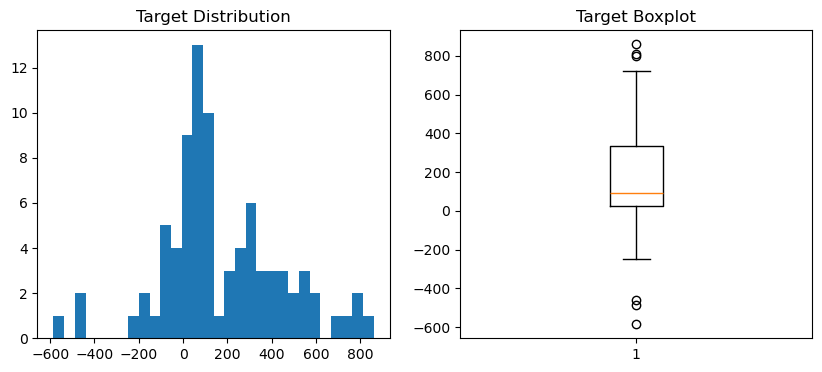

In [3]:
df = pd.read_excel("generated_data_1.xlsx", sheet_name="Sample Data")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Epit'], bins=30)
plt.title("Target Distribution")
plt.subplot(1, 2, 2)
plt.boxplot(df['Epit'])
plt.title("Target Boxplot")
plt.show()

# WGAN-GP Class

In [ ]:
class WGAN_GP:
    def __init__(self, comp_dim=7, gp_lambda=10.0, latent_dim=16,
                 g_hidden=128, d_hidden=128, n_critic=5,
                 lr=1e-4, beta_1=0.0, beta_2=0.9, seed=42):
        """
        comp_dim : Composition Dimension
        gp_lambda: Gradient penalty coefficient
        latent_dim: Noise dimension
        n_critic : Number of critic training steps per generator training step
        """
        tf.random.set_seed(seed)
        np.random.seed(seed)

        self.comp_dim   = comp_dim
        self.other_dim  = None
        self.scaler_other = None

        self.latent_dim = latent_dim
        self.gp_lambda  = gp_lambda
        self.n_critic   = n_critic

        self.g_optimizer = tf.keras.optimizers.Adam(lr, beta_1, beta_2)
        self.d_optimizer = tf.keras.optimizers.Adam(lr, beta_1, beta_2)

        self.g_hidden = g_hidden
        self.d_hidden = d_hidden

        self.generator = None
        self.critic    = None

        self.X_comp = None
        self.X_other = None
        self.train_data = None

    # ---------- Data Loading and Preprocessing ----------
    def load_data(self, data):
        """
        data: ndarray or DataFrame
        """
        X = data.values if isinstance(data, pd.DataFrame) else data
        assert X.ndim == 2 and X.shape[1] > self.comp_dim, "数据列数必须 > comp_dim"

        comp  = X[:, :self.comp_dim].astype(np.float32)
        other = X[:, self.comp_dim:].astype(np.float32)
        self.other_dim = other.shape[1]
        comp = np.clip(comp, 0.0, None)
        s = comp.sum(axis=1, keepdims=True)
        s[s == 0] = 1.0
        comp = comp / s
        self.scaler_other = MinMaxScaler(feature_range=(-1, 1))
        other_scaled = self.scaler_other.fit_transform(other).astype(np.float32)

        self.train_data = np.concatenate([comp, other_scaled], axis=1).astype(np.float32)
        self.X_comp  = comp
        self.X_other = other
        print(f"[load_data] comp_dim={self.comp_dim}, other_dim={self.other_dim}, n={X.shape[0]}")

    # ---------- Model ----------
    def build_generator(self):
        z = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.g_hidden, activation='relu')(z)
        x = layers.Dense(self.g_hidden, activation='relu')(x)
        comp_logits = layers.Dense(self.comp_dim)(x)
        comp_softmax = layers.Activation('softmax', name='comp_softmax')(comp_logits)
        other_tanh = layers.Dense(self.other_dim, activation='tanh', name='other_tanh')(x)

        out = layers.Concatenate(name='gen_out')([comp_softmax, other_tanh])
        self.generator = Model(z, out, name='Generator')
        return self.generator

    def build_critic(self):
        inp = layers.Input(shape=(self.comp_dim + self.other_dim,))
        x = layers.Dense(self.d_hidden, activation='relu')(inp)
        x = layers.Dense(self.d_hidden, activation='relu')(x)
        out = layers.Dense(1, activation=None)(x)   # 线性输出
        self.critic = Model(inp, out, name='Critic')
        return self.critic

    # ---------- Loss & Gradient Penalty ----------
    @staticmethod
    def wasserstein_loss(real_scores, fake_scores):
        return tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)

    def gradient_penalty(self, real_samples, fake_samples):
        batch_size = tf.shape(real_samples)[0]
        epsilon = tf.random.uniform([batch_size, 1], 0.0, 1.0)
        # broadcast to sample dimension
        epsilon = tf.broadcast_to(epsilon, tf.shape(real_samples))
        x_hat = epsilon * real_samples + (1 - epsilon) * fake_samples
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(x_hat)
            d_hat = self.critic(x_hat, training=True)
        grads = gp_tape.gradient(d_hat, [x_hat])[0]
        # L2 norm of each sample
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
        gp = tf.reduce_mean(tf.square(grad_norm - 1.0))
        return gp

    # ---------- Single Training Step ----------
    @tf.function
    def train_critic_step(self, real_batch):
        z = tf.random.normal([tf.shape(real_batch)[0], self.latent_dim])

        with tf.GradientTape() as tape:
            fake_batch = self.generator(z, training=True)
            d_real = self.critic(real_batch, training=True)
            d_fake = self.critic(fake_batch, training=True)

            w_loss = self.wasserstein_loss(d_real, d_fake)
            gp = self.gradient_penalty(real_batch, fake_batch)
            d_loss = w_loss + self.gp_lambda * gp

        grads = tape.gradient(d_loss, self.critic.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        return d_loss, w_loss, gp

    @tf.function
    def train_generator_step(self, batch_size):
        z = tf.random.normal([batch_size, self.latent_dim])
        with tf.GradientTape() as tape:
            fake_batch = self.generator(z, training=True)
            d_fake = self.critic(fake_batch, training=True)
            # Generator aims to minimize E[fake]
            g_loss = -tf.reduce_mean(d_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        return g_loss

    # ---------- Main Training Loop ----------
    def train(self, epochs=2000, batch_size=128, log_every=100):

        self.build_generator()
        self.build_critic()

        ds = tf.data.Dataset.from_tensor_slices(self.train_data)\
                            .shuffle(buffer_size=len(self.train_data))\
                            .batch(batch_size, drop_remainder=True)\
                            .prefetch(tf.data.AUTOTUNE)

        step = 0
        for epoch in range(1, epochs + 1):
            for real_batch in ds:
                for _ in range(self.n_critic):
                    d_loss, w_loss, gp = self.train_critic_step(real_batch)
                g_loss = self.train_generator_step(tf.shape(real_batch)[0])

                step += 1

            if epoch % log_every == 0 or epoch == 1:
                print(f"Epoch {epoch}/{epochs} | "
                      f"D: {d_loss.numpy():.4f} (W:{w_loss.numpy():.4f}, GP:{gp.numpy():.4f}) "
                      f"| G: {g_loss.numpy():.4f}")

        print("[train] done.")

    # ---------- Sampling ----------
    def generate(self, num_samples=200, return_df=False, columns=None):
        """
        Output = [comp_softmax, inverse_transform(other_tanh)]
        """
        z = tf.random.normal([num_samples, self.latent_dim])
        gen = self.generator(z, training=False).numpy()

        gen_comp = gen[:, :self.comp_dim]              
        gen_other_scaled = gen[:, self.comp_dim:]
        gen_other = self.scaler_other.inverse_transform(gen_other_scaled)

        out = np.concatenate([gen_comp, gen_other], axis=1)

        if return_df:
            if columns is None:
                columns = [f"elem_{i+1}" for i in range(self.comp_dim)] + \
                          [f"feat_{i+1}" for i in range(self.other_dim)]
            return pd.DataFrame(out, columns=columns)
        return out


# Data Generation

In [ ]:
gan = WGAN_GP(
    comp_dim=7, latent_dim=16,
    gp_lambda=10.0, n_critic=5,
    g_hidden=128, d_hidden=128,
    lr=1e-4, beta_1=0.0, beta_2=0.9
)

gan.load_data(df)
gan.train(epochs=4000, batch_size=64, log_every=100)
samples = gan.generate(500, return_df=True,
                       columns=df.columns.tolist())
samples.describe()


[load_data] comp_dim=7, other_dim=19, n=83
Epoch 1/4000 | D: 3.8539 (W:-0.1327, GP:0.3987) | G: -0.1188


2025-08-20 18:43:08.368758: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 100/4000 | D: -0.8885 (W:-0.9280, GP:0.0039) | G: -0.9507
Epoch 200/4000 | D: -0.6440 (W:-0.6947, GP:0.0051) | G: -0.2217
Epoch 300/4000 | D: -0.4674 (W:-0.5296, GP:0.0062) | G: -0.2782
Epoch 400/4000 | D: -0.4970 (W:-0.5778, GP:0.0081) | G: 0.2024
Epoch 500/4000 | D: -0.5010 (W:-0.5767, GP:0.0076) | G: 0.2553
Epoch 600/4000 | D: -0.5047 (W:-0.6155, GP:0.0111) | G: 0.1730
Epoch 700/4000 | D: -0.5049 (W:-0.6134, GP:0.0109) | G: 0.1877
Epoch 800/4000 | D: -0.5624 (W:-0.6457, GP:0.0083) | G: 0.1739
Epoch 900/4000 | D: -0.4524 (W:-0.5314, GP:0.0079) | G: 0.2493
Epoch 1000/4000 | D: -0.4922 (W:-0.5723, GP:0.0080) | G: 0.1852
Epoch 1100/4000 | D: -0.4627 (W:-0.5333, GP:0.0071) | G: 0.2195
Epoch 1200/4000 | D: -0.3655 (W:-0.4597, GP:0.0094) | G: 0.2368
Epoch 1300/4000 | D: -0.3992 (W:-0.4726, GP:0.0073) | G: 0.2679
Epoch 1400/4000 | D: -0.3769 (W:-0.4450, GP:0.0068) | G: 0.2406
Epoch 1500/4000 | D: -0.4548 (W:-0.5512, GP:0.0096) | G: 0.3283
Epoch 1600/4000 | D: -0.4156 (W:-0.5203, GP:0.

,Fe,Cr,Ni,Mn,Al,Cu,Co,E_M-M,pH of zero charge of oxides_Aver,Gibbs free energy of oxide formation_Aver,...,Energy of ionization second_Aver,Oxidation state first_Aver,Valence electron number_Aver,Work function of oxides_Aver,Heat of adsorption of oxygen_Aver,band gap_Aver,Enthalpy of melting_Aver,dr,S,Epit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.242028,0.207933,0.229292,0.044608,0.023255,0.042170,0.210715,81.310074,8.415317,-94.312355,...,1650.020508,1.988199,8.204053,5.114154,548.742126,2.969699,16.508459,0.021200,12.389420,190.020691
std,0.070958,0.056322,0.050864,0.064404,0.040645,0.066272,0.060655,3.452498,0.343173,42.122662,...,25.890528,0.086432,0.366686,0.052123,30.840162,0.297212,0.583437,0.015321,1.097588,266.017548
min,0.081357,0.008149,0.083321,0.000030,0.000024,0.000053,0.017546,69.204315,7.460048,-228.525543,...,1596.995972,1.767578,7.296957,4.982994,439.638245,2.443514,14.806292,0.001696,9.400386,-520.192139
25%,0.201555,0.181992,0.197313,0.005350,0.002138,0.005263,0.179163,79.408175,8.292910,-105.971424,...,1634.498718,1.946788,7.992739,5.080268,535.639023,2.772979,16.157394,0.007550,11.566610,1.937417
50%,0.233187,0.213348,0.225791,0.018639,0.007181,0.014420,0.223563,82.403366,8.466602,-86.335938,...,1648.547546,2.000624,8.230773,5.115994,548.357422,2.930158,16.561336,0.018399,12.268343,117.511982
75%,0.265960,0.241227,0.255947,0.054123,0.021826,0.043171,0.246864,83.888462,8.582802,-75.651751,...,1663.739410,2.024726,8.379742,5.149193,565.047607,3.074829,16.920286,0.032195,13.277090,354.870491
max,0.575967,0.429963,0.442462,0.464856,0.327779,0.359687,0.352282,86.335838,9.255979,30.128475,...,1741.660645,2.219104,9.477660,5.252363,631.530151,3.895406,18.372814,0.066964,14.760211,849.110657


In [22]:
df.describe()

,Fe,Cr,Ni,Mn,Al,Cu,Co,E_M-M,pH of zero charge of oxides_Aver,Gibbs free energy of oxide formation_Aver,...,Energy of ionization second_Aver,Oxidation state first_Aver,Valence electron number_Aver,Work function of oxides_Aver,Heat of adsorption of oxygen_Aver,band gap_Aver,Enthalpy of melting_Aver,dr,S,Epit
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,...,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.239551,0.207775,0.227775,0.045204,0.024498,0.044952,0.212944,80.979292,8.426775,-91.476936,...,1655.254571,1.984944,8.241702,5.123041,547.635500,2.966998,16.505142,0.023135,12.443882,174.125301
std,0.072769,0.067522,0.048042,0.080091,0.047947,0.075232,0.069119,3.836747,0.377207,47.583005,...,43.838339,0.107659,0.438001,0.129396,39.427638,0.320838,0.731285,0.024569,1.187749,275.003295
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,68.132667,7.454000,-238.730000,...,1595.200000,1.750000,7.200000,4.964250,435.920000,2.396000,14.740000,0.001685,9.133863,-585.000000
25%,0.200000,0.200000,0.200000,0.000000,0.000000,0.000000,0.200000,78.775062,8.314000,-108.984000,...,1638.000000,1.888889,7.943750,5.071889,519.236190,2.756000,16.040000,0.003153,11.525651,27.500000
50%,0.232558,0.222222,0.222222,0.000000,0.000000,0.000000,0.222222,81.701646,8.475000,-85.251538,...,1650.517300,2.000000,8.250000,5.122000,546.920000,2.950000,16.616279,0.022981,12.647715,90.000000
75%,0.250000,0.250000,0.250000,0.052551,0.027195,0.111111,0.250000,84.107983,8.533333,-59.615556,...,1673.555555,2.012545,8.555556,5.141860,568.336000,3.181818,17.073958,0.034548,13.249722,335.000000
max,0.400000,0.333333,0.400000,0.202801,0.200000,0.250000,0.333333,88.286000,9.300000,31.987500,...,1937.133333,2.400000,9.500000,6.190667,715.066667,3.960000,20.013333,0.184748,14.896688,860.000000


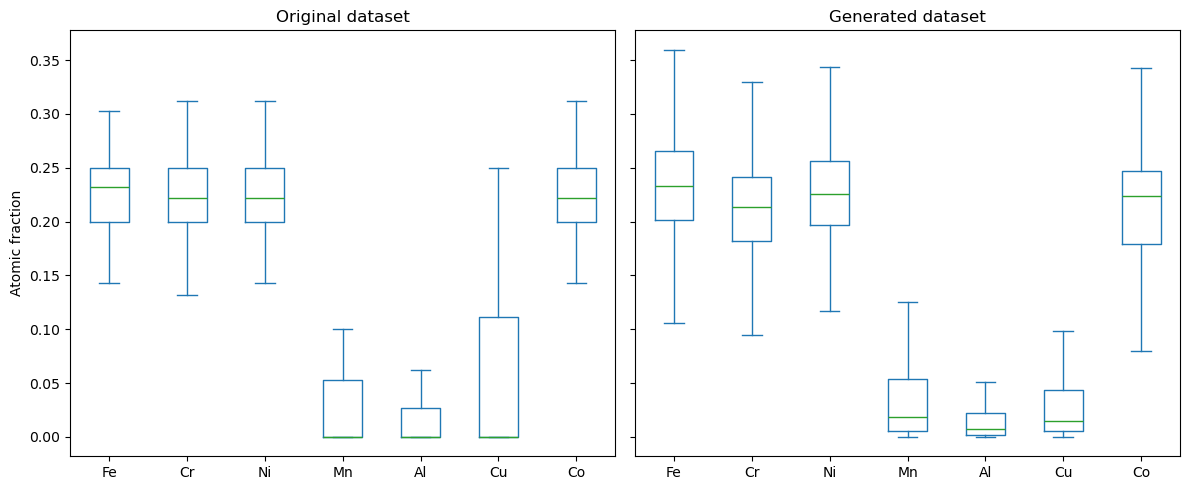

In [ ]:
cols = ['Fe','Cr','Ni','Mn','Al','Cu','Co']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
df[cols].plot(kind='box', ax=axes[0], title='Original dataset', showfliers=False)
samples[cols].plot(kind='box', ax=axes[1], title='Generated dataset', showfliers=False)

for ax in axes:
    ax.set_ylabel('Atomic fraction')

plt.tight_layout()
plt.show()


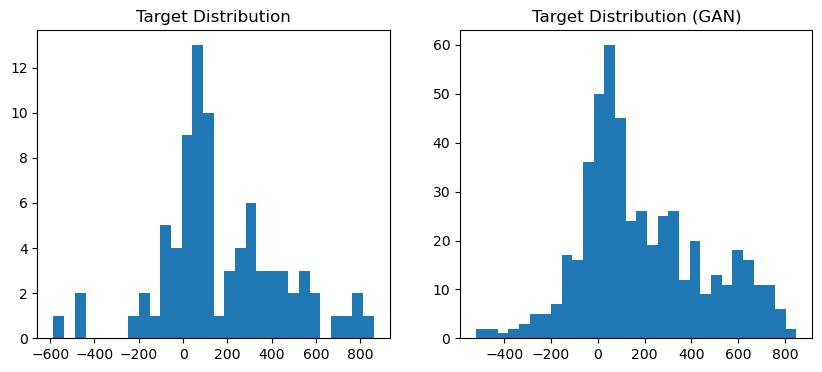

In [23]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Epit'], bins=30)
plt.title("Target Distribution")
plt.subplot(1, 2, 2)
plt.hist(samples['Epit'], bins=30)
plt.title("Target Distribution (GAN)")
plt.show()

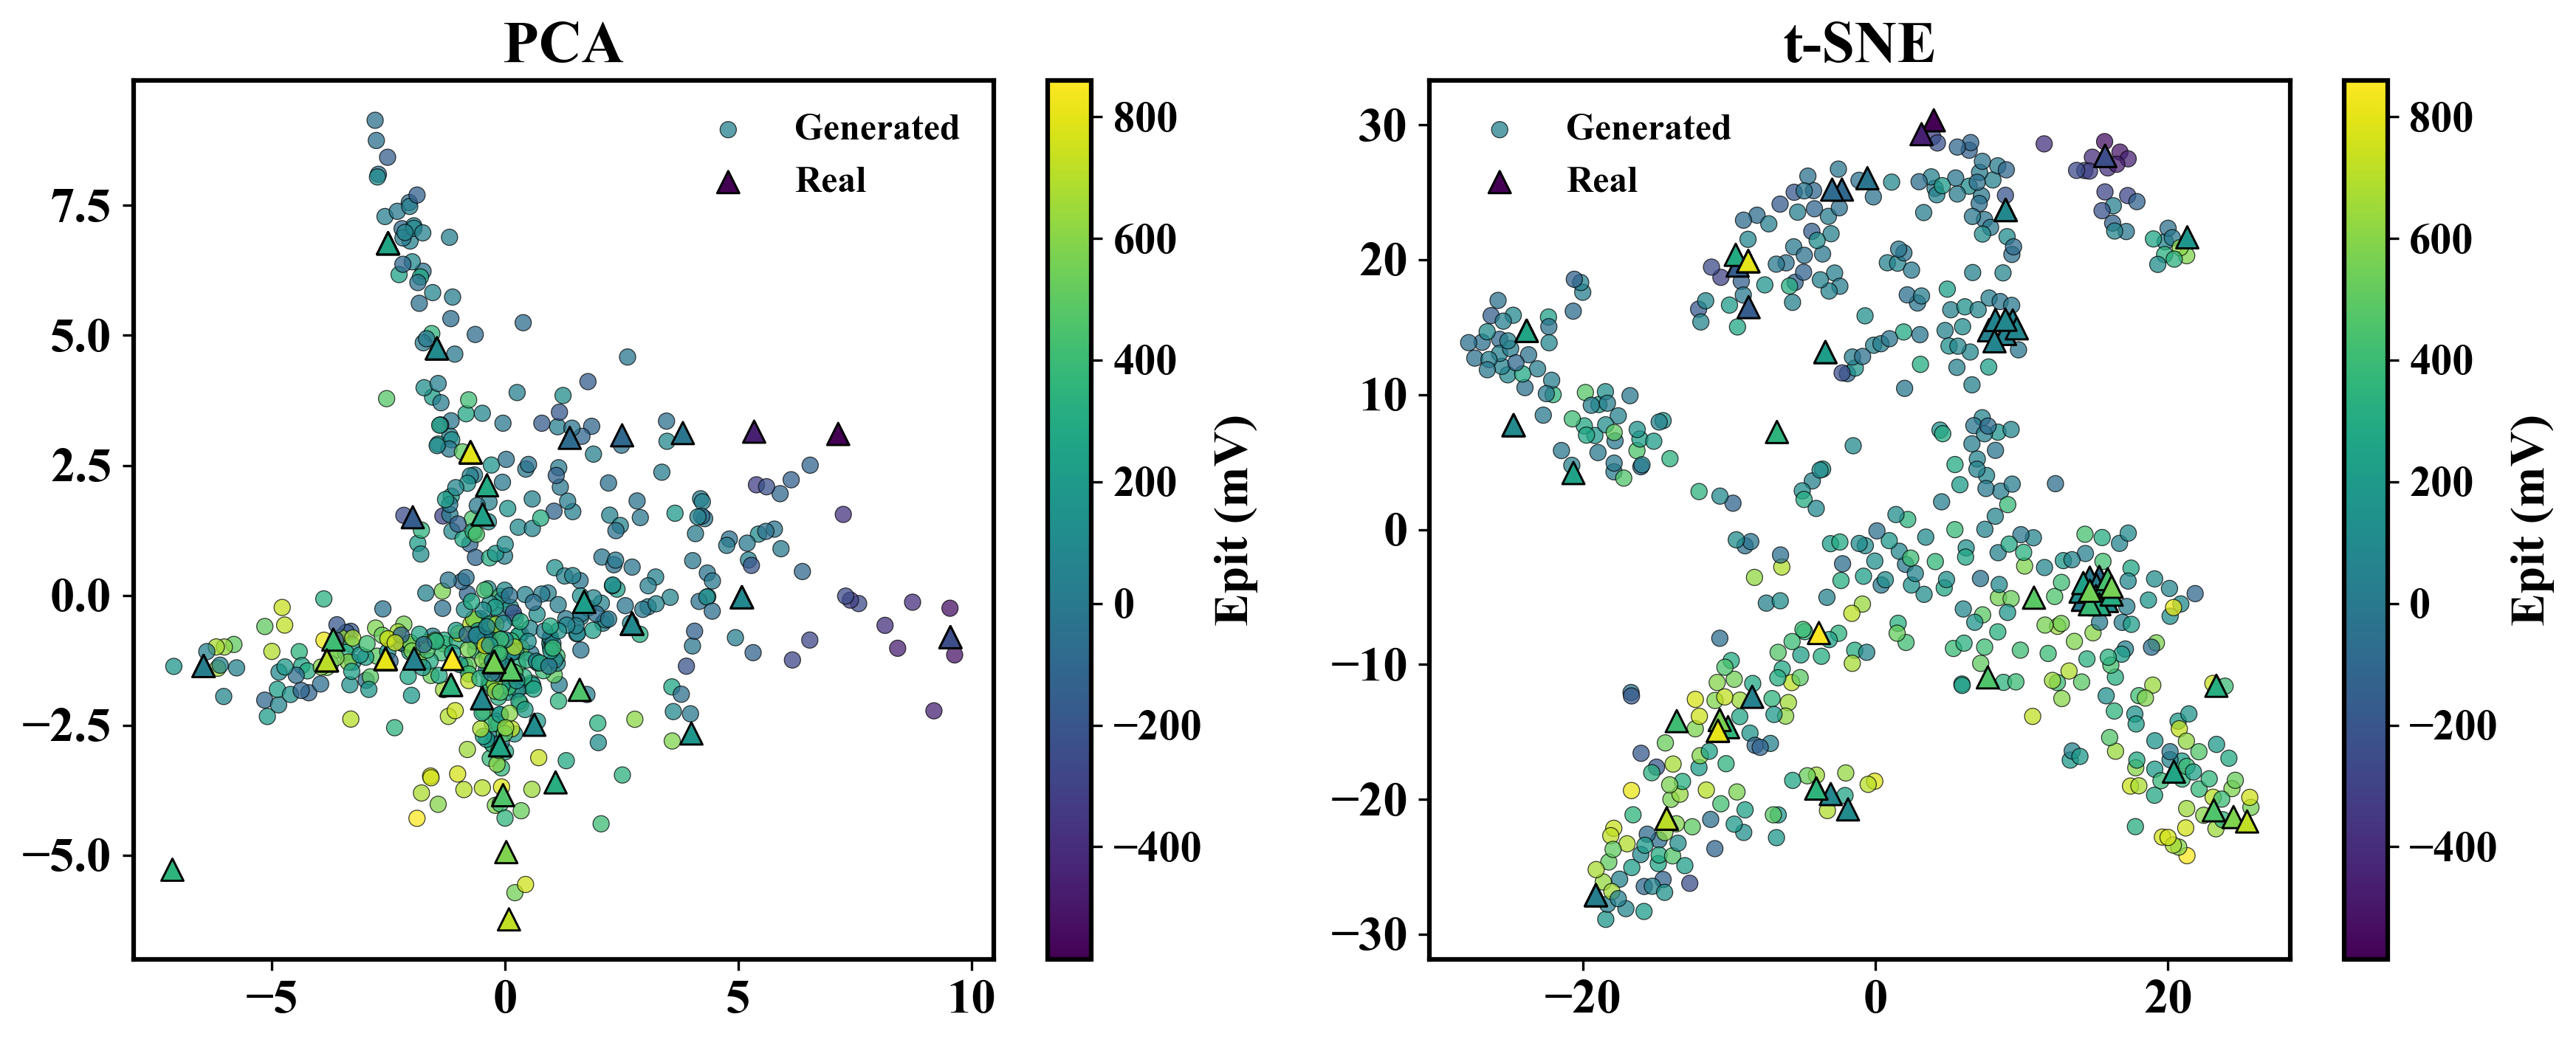

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=y.min(), vmax=y.max())
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

s_real = 52
s_gen  = 28
alpha_gen = 0.75   
lw_real = 0.7
lw_gen  = 0.3

ax = axes[0]

ax.scatter(
    X_pca[src==1, 0], X_pca[src==1, 1],
    s=s_gen,
    c=cmap(norm(y[src==1])),
    marker='o',
    edgecolors='k',
    linewidths=lw_gen,
    alpha=alpha_gen,     
    label='Generated',
    zorder=1
)

ax.scatter(
    X_pca[src==0, 0], X_pca[src==0, 1],
    s=s_real,
    c=cmap(norm(y[src==0])),
    marker='^',
    edgecolors='k',
    linewidths=lw_real,
    alpha=1.0,
    label='Real',
    zorder=2
)

ax.set_title("PCA", fontweight="bold")
ax.legend(frameon=False, fontsize=12)

cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label("Epit (mV)", fontweight="bold")
cbar.ax.tick_params(labelsize=14)

ax = axes[1]
ax.scatter(
    X_tsne[src==1, 0], X_tsne[src==1, 1],
    s=s_gen,
    c=cmap(norm(y[src==1])),
    marker='o',
    edgecolors='k',
    linewidths=lw_gen,
    alpha=alpha_gen,     
    label='Generated',
    zorder=1
)

ax.scatter(
    X_tsne[src==0, 0], X_tsne[src==0, 1],
    s=s_real,
    c=cmap(norm(y[src==0])),
    marker='^',
    edgecolors='k',
    linewidths=lw_real,
    alpha=1.0,
    label='Real',
    zorder=2
)

ax.set_title("t-SNE", fontweight="bold")
ax.legend(frameon=False, fontsize=12)

cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label("Epit (mV)", fontweight="bold")
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


In [ ]:
Xz = StandardScaler().fit_transform(X)
clf = LogisticRegression(max_iter=200).fit(Xz, src)
auc = roc_auc_score(src, clf.predict_proba(Xz)[:,1])
print(f"Domain AUC (real vs gen): {auc:.3f}")

Domain AUC (real vs gen): 0.689


# MMD

In [ ]:
from scipy.spatial.distance import cdist

def rbf_kernel(X, Y=None, sigma=None):
    if Y is None: Y = X
    D2 = cdist(X, Y, metric='sqeuclidean')  
    if sigma is None:
        Z = np.vstack([X, Y])
        ZD2 = cdist(Z, Z, metric='sqeuclidean')
        med2 = np.median(ZD2[ZD2>0])  # avoid zeros
        sigma = np.sqrt(med2 / 2.0) if med2 > 0 else 1.0
    K = np.exp(-D2 / (2.0 * sigma**2))
    return K, sigma

def mmd2_unbiased(X, Y, sigma=None):
    Kxx, sigma = rbf_kernel(X, X, sigma)
    Kyy, _     = rbf_kernel(Y, Y, sigma)
    Kxy, _     = rbf_kernel(X, Y, sigma)

    n = len(X); m = len(Y)
    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)
    term_xx = Kxx.sum() / (n*(n-1))
    term_yy = Kyy.sum() / (m*(m-1))
    term_xy = Kxy.mean()
    return term_xx + term_yy - 2*term_xy, sigma 

def mmd_permutation_test(X, Y, B=1000, alpha=0.05, sigma=None, random_state=0):
    rng = np.random.default_rng(random_state)
    n, m = len(X), len(Y)
    Z = np.vstack([X, Y])
    mmd2_obs, sigma_used = mmd2_unbiased(X, Y, sigma)
    mmd2_null = np.empty(B)
    for b in range(B):
        idx = rng.permutation(n+m)
        Xb = Z[idx[:n]]
        Yb = Z[idx[n:]]
        mmd2_null[b], _ = mmd2_unbiased(Xb, Yb, sigma_used)
    p = (np.sum(mmd2_null >= mmd2_obs) + 1) / (B + 1)
    crit = np.quantile(mmd2_null, 1 - alpha)

    return {
        "mmd2_obs": mmd2_obs,
        "mmd_obs": np.sqrt(max(mmd2_obs, 0.0)),
        "sigma_used": sigma_used,
        "p_value": p,
        "crit_mmd2": crit,
        "crit_mmd": np.sqrt(max(crit, 0.0)),
        "null_samples": mmd2_null
    }



In [13]:
res = mmd_permutation_test(X_gen, X_real, B=2000, alpha=0.05, random_state=42)

print(f"MMD = {res['mmd_obs']:.8f}")
print(f"p-value = {res['p_value']:.3f}")
print(f"Critical MMD (α=0.05) = {res['crit_mmd']:.5f}")

MMD = 0.05012180
p-value = 0.218
Critical MMD (α=0.05) = 0.09236


In [ ]:
from scipy.stats import ks_2samp 
Xr, Xg = X_real, X_gen
ks = [ks_2samp(Xr[:,j], Xg[:,j]).pvalue for j in range(X.shape[1])]
print("Median KS p-value across features:", np.median(ks))


Median KS p-value across features: 0.07278115076743126


In [ ]:
def corr_diff(A, B):
    Ca = np.corrcoef(A, rowvar=False); Cb = np.corrcoef(B, rowvar=False)
    return np.linalg.norm(Ca - Cb, ord='fro') / np.linalg.norm(Ca, ord='fro')
print("Correlation structure distance:", corr_diff(X_real, X_gen))

Correlation structure distance: 0.533989689723245
